In [ ]:
#Installing the required packages with pip
!pip install mxnet-cu101
!pip install d2l
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install sklearn
!pip install seaborn
!pip install mlxtend
!pip install torch
!pip install platform
#Importing the required packages

In [3]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns

import matplotlib.pyplot as plt

from mlxtend.data import loadlocal_mnist
import platform
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


## Load data

In [5]:
X_train, y_train = loadlocal_mnist(
    images_path='train-images.idx3-ubyte', 
    labels_path='train-labels.idx1-ubyte')
X_test, y_test = loadlocal_mnist(
    images_path='t10k-images.idx3-ubyte', 
    labels_path='t10k-labels.idx1-ubyte')

In [6]:
print('Train images:', X_train.shape)
print('Train labels:', y_train.shape)
print('Test images:', X_test.shape)
print('Test labels:', y_test.shape)

Train images: (60000, 784)
Train labels: (60000,)
Test images: (10000, 784)
Test labels: (10000,)


In [7]:
pixel_col = ['pixel'] * X_train.shape[1]
concatenar = lambda x,y: x + "" + str(y)
columnas = list(map(concatenar, pixel_col, list(range( X_train.shape[1]))))

train = pd.DataFrame(X_train, columns = columnas)
train.insert(0, 'label', y_train, True)

test = pd.DataFrame(X_test, columns = columnas)
test.insert(0, 'label', y_test, True)

In [8]:
train.to_csv('train.csv', index = False)
test.to_csv('test.csv', index = False)

## Architecture

In [9]:
# Read the training and testing data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
test_x = test.iloc[:,1:]
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# Split train and validation sets
train_x, valid_x, train_y, valid_y = train_test_split(train.iloc[:,1:], 
                                                      train.iloc[:,0], 
                                                      test_size=0.1)
print("Training set size: {}".format(train_x.shape))
print("Validation set size: {}".format(valid_x.shape))
print("Test set size: {}".format(test_x.shape))

Training set size: (54000, 784)
Validation set size: (6000, 784)
Test set size: (10000, 784)


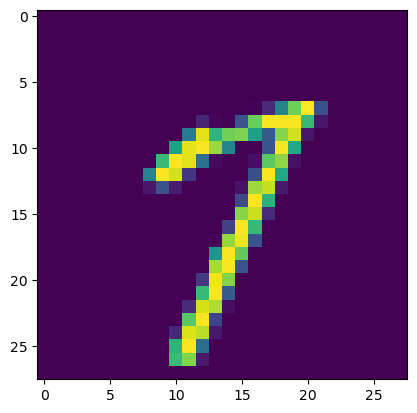

In [11]:
# Example training data
plt.imshow(train_x.iloc[5].values.reshape(28, 28))

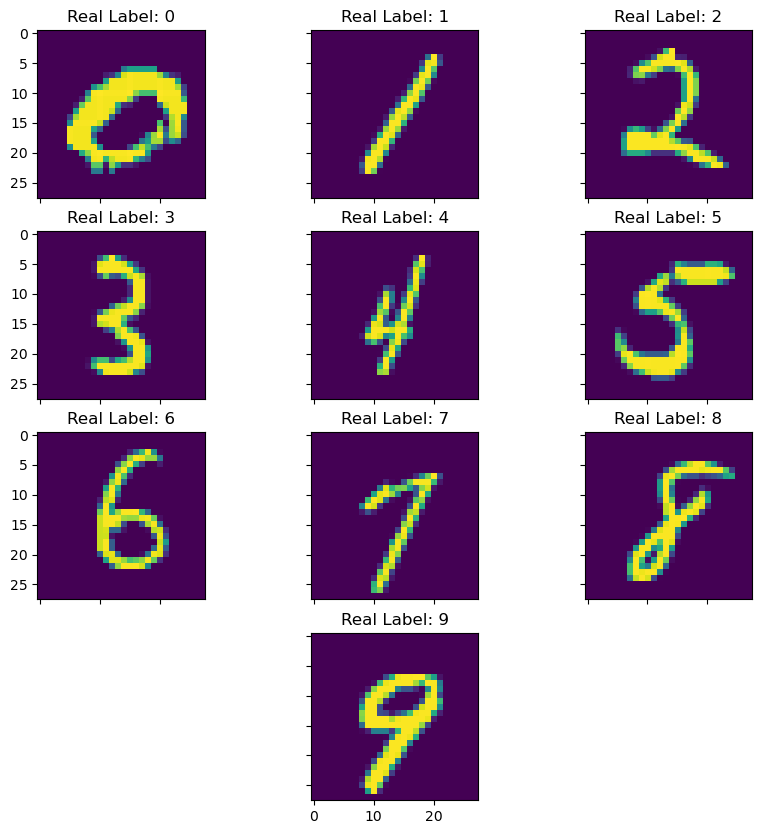

In [12]:
fig, axs = plt.subplots(4, 3, figsize=(10,10))
axs[0, 0].imshow(train_x[train_y == 0].iloc[0].values.reshape(28, 28))
axs[0, 0].set_title('Real Label: 0')
axs[0, 1].imshow(train_x[train_y == 1].iloc[0].values.reshape(28, 28))
axs[0, 1].set_title('Real Label: 1')
axs[0, 2].imshow(train_x[train_y == 2].iloc[0].values.reshape(28, 28))
axs[0, 2].set_title('Real Label: 2')
axs[1, 0].imshow(train_x[train_y == 3].iloc[0].values.reshape(28, 28))
axs[1, 0].set_title('Real Label: 3')
axs[1, 1].imshow(train_x[train_y == 4].iloc[0].values.reshape(28, 28))
axs[1, 1].set_title('Real Label: 4')
axs[1, 2].imshow(train_x[train_y == 5].iloc[0].values.reshape(28, 28))
axs[1, 2].set_title('Real Label: 5')
axs[2, 0].imshow(train_x[train_y == 6].iloc[0].values.reshape(28, 28))
axs[2, 0].set_title('Real Label: 6')
axs[2, 1].imshow(train_x[train_y == 7].iloc[0].values.reshape(28, 28))
axs[2, 1].set_title('Real Label: 7')
axs[2, 2].imshow(train_x[train_y == 8].iloc[0].values.reshape(28, 28))
axs[2, 2].set_title('Real Label: 8')
axs[3, 1].imshow(train_x[train_y == 9].iloc[0].values.reshape(28, 28))
axs[3, 1].set_title('Real Label: 9')
fig.delaxes(axs[3,0]) #The indexing is zero-based here
fig.delaxes(axs[3,2]) #The indexing is zero-based here

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [13]:
# LeNet-5 Model architecture
def model(train_x, train_y, valid_x, valid_y, test_x, learning_rate=0.0001, batch_size=128, num_epochs=1000):
    
    # Create placeholder for model input and label.
    # Input shape is (minbatch_size, 28, 28)
    X = tf.placeholder(tf.float32, [None, 28, 28], name="X")
    Y = tf.placeholder(tf.int64, [None, ], name="Y")
    
    def CNN(X):
        # Here we defind the CNN architecture (LeNet-5)
        
        # Reshape input to 4-D vector
        input_layer = tf.reshape(X, [-1, 28, 28, 1]) # -1 adds minibatch support.
        
        # Padding the input to make it 32x32. Specification of LeNET
        padded_input = tf.pad(input_layer, [[0, 0], [2, 2], [2, 2], [0, 0]], "CONSTANT") 
        
        # Convolutional Layer #1
        # Has a default stride of 1
        # Output: 28 * 28 * 6
        conv1 = tf.layers.conv2d(
          inputs=padded_input,
          filters=6, # Number of filters.
          kernel_size=5, # Size of each filter is 5x5.
          padding="valid", # No padding is applied to the input.
          activation=tf.nn.relu)

        # Pooling Layer #1
        # Sampling half the output of previous layer
        # Output: 14 * 14 * 6
        pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
        # Convolutional Layer #2
        # Output: 10 * 10 * 16
        conv2 = tf.layers.conv2d(
          inputs=pool1,
          filters=16, # Number of filters
          kernel_size=5, # Size of each filter is 5x5
          padding="valid", # No padding
          activation=tf.nn.relu)

        # Pooling Layer #2
        # Output: 5 * 5 * 16
        pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

        # Reshaping output into a single dimention array for input to fully connected layer
        pool2_flat = tf.reshape(pool2, [-1, 5 * 5 * 16])
        
        # Fully connected layer #1: Has 120 neurons
        dense1 = tf.layers.dense(inputs=pool2_flat, units=120, activation=tf.nn.relu)

        # Fully connected layer #2: Has 84 neurons
        dense2 = tf.layers.dense(inputs=dense1, units=84, activation=tf.nn.relu)

        # Output layer, 10 neurons for each digit
        logits = tf.layers.dense(inputs=dense2, units=10)
        
        return logits
    
    # Pass the input thorough our CNN
    logits = CNN(X)
    softmax = tf.nn.softmax(logits)
    
    # Convert our labels into one-hot-vectors
    labels = tf.one_hot(indices=tf.cast(Y, tf.int32), depth=10)
    
    # Compute the cross-entropy loss
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,
                                                                     labels=labels))
    
    # Use adam optimizer to reduce cost
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(cost)
    
    
    # For testing and prediction
    predictions = tf.argmax(softmax, axis=1)
    correct_prediction = tf.equal(predictions, Y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    
    # Initialize all the variables
    init = tf.global_variables_initializer()
    
    
    # Running the model
    with tf.Session() as sess:
 
        sess.run(init)
        
        for epoch in range(num_epochs):
            num_samples = train_x.shape[0]
            num_batches = (num_samples // batch_size) + 1
            epoch_cost = 0.
            i = 0
            while i < num_samples:
                batch_x = train_x.iloc[i:i+batch_size,:].values
                batch_x = batch_x.reshape(batch_x.shape[0], 28, 28)

                batch_y = train_y.iloc[i:i+batch_size].values

                i += batch_size

                # Train on batch and get back cost
                _, c = sess.run([train_op, cost], feed_dict={X:batch_x, Y:batch_y})
                epoch_cost += (c/num_batches)
                
            # Get accuracy for validation
            valid_accuracy = accuracy.eval(
                feed_dict={X:valid_x.values.reshape(valid_x.shape[0], 28, 28),
                           Y:valid_y.values})
            print ("Epoch {}: Cost: {}".format(epoch+1, epoch_cost))
            print("Validation accuracy: {}".format(valid_accuracy))
            
        return predictions.eval(feed_dict={X:test_x.values.reshape(test_x.shape[0], 28, 28)})

In [14]:
# Run for more epochs for better accuracy
predictions = model(train_x, train_y, valid_x, valid_y, test_x, learning_rate=0.0001, batch_size=64, num_epochs=5)

# Examples of what predictions look like
print("First 5 test predictions: {}".format(predictions[:5]))

/tmp/ipykernel_2711/3254898848.py:21: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  conv1 = tf.layers.conv2d(
/tmp/ipykernel_2711/3254898848.py:31: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a future version. Please use `tf.keras.layers.MaxPooling2D` instead.
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
/tmp/ipykernel_2711/3254898848.py:34: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  conv2 = tf.layers.conv2d(
/tmp/ipykernel_2711/3254898848.py:43: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a future version. Please use `tf.keras.layers.MaxPooling2D` instead.
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
/tmp/ipykernel_2711/3254898848.py:49: UserWarning: `tf.layers.dense` is deprecated a

Epoch 1: Cost: 1.6848356302704017
Validation accuracy: 0.890999972820282
Epoch 2: Cost: 0.34471467900932995
Validation accuracy: 0.9279999732971191
Epoch 3: Cost: 0.2115237474876292
Validation accuracy: 0.9484999775886536
Epoch 4: Cost: 0.14948648554068794
Validation accuracy: 0.9570000171661377
Epoch 5: Cost: 0.11177304086026568
Validation accuracy: 0.9610000252723694
First 5 test predictions: [7 2 1 0 4]


In [15]:
#Submission
test.insert(1, 'Pred', predictions, True)
test.to_csv('submit.csv', index = False)

In [16]:
cm = confusion_matrix(test['label'], test['Pred'])
cm_df = pd.DataFrame(cm,
                     index = list(range(10)), 
                     columns = list(range(10)))
cm

array([[ 960,    0,    4,    0,    0,    1,    6,    2,    6,    1],
       [   0, 1126,    4,    0,    0,    1,    1,    1,    2,    0],
       [   5,    3,  994,    4,    1,    1,    4,    7,   11,    2],
       [   0,    2,    4,  981,    0,    9,    1,    3,    8,    2],
       [   1,    3,    4,    0,  951,    0,    8,    2,    4,    9],
       [   1,    1,    0,   10,    1,  859,    7,    2,    8,    3],
       [   7,    3,    0,    0,    5,   10,  931,    0,    2,    0],
       [   0,    4,   16,    6,    0,    1,    0,  987,    4,   10],
       [   0,    3,    4,   10,    7,    5,    3,    5,  935,    2],
       [   6,    3,    1,    7,   20,    9,    1,    5,   12,  945]])

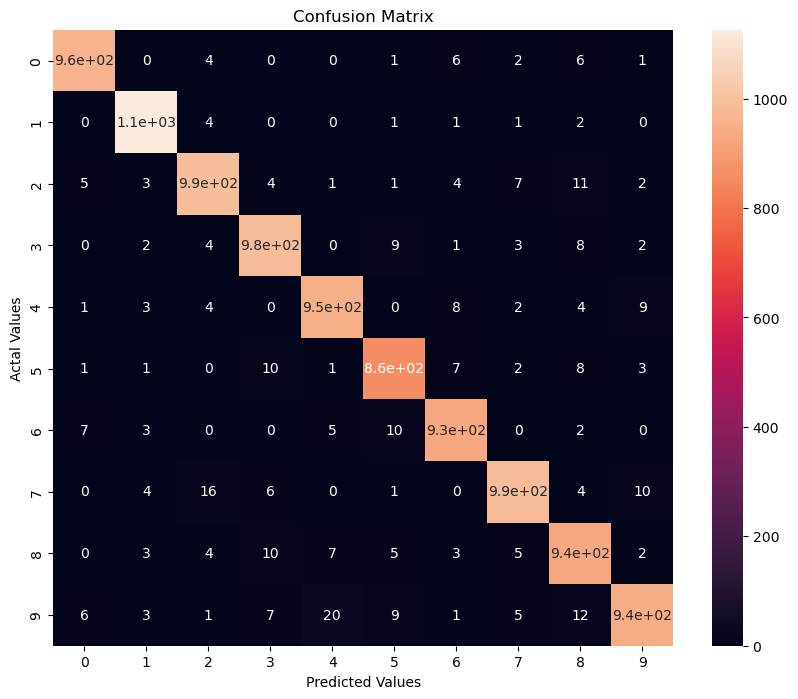

In [17]:
#Plotting the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [18]:
print('Accuracy:',accuracy_score(test['label'], test['Pred']))
print('Precision:', precision_score(test['label'], test['Pred'], average='macro'))
print('Recall:', recall_score(test['label'], test['Pred'], average='macro'))
print('F1-Score:', f1_score(test['label'], test['Pred'], average='macro'))

Accuracy: 0.9669
Precision: 0.9666296844517746
Recall: 0.9666026810722121
F1-Score: 0.9665681106370337
